### online source on HDF5Matrix

In [15]:
"""How to do data augmentation on a keras HDF5Matrix"""
from keras.utils.io_utils import HDF5Matrix


class AugmentedHDF5Matrix(HDF5Matrix):
    """Wraps HDF5Matrixs with image augumentation."""

    def __init__(self, image_datagen, seed, *args, **kwargs):
        self.image_datagen = image_datagen
        self.seed = seed
        self.i = 0
        super().__init__(*args, **kwargs)

    def __getitem__(self, key):
        x = super().__getitem__(key)
        self.i += 1
        if len(x.shape) == 3:
            return self.image_datagen.random_transform(
                x, seed=self.seed + self.i)
        else:
            return np.array([
                self.image_datagen.random_transform(
                    xx, seed=self.seed + self.i) for xx in x
            ])


# Test
from keras.preprocessing.image import ImageDataGenerator
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt

# a keras imagedata generator
image_datagen = ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    channel_shift_range=0.005,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
    rescale=1/255.0)

# # test h5 file
# images = np.random.random((100, 244, 244, 3))
# images[:, 20:30, 20:50, :] = 1
# images[:, 50:70, 20:30, :] = 0
# datapath = "/tmp/testfile5.hdf5"
# if os.path.isfile(datapath):
#     os.remove(datapath)
# with h5py.File(datapath, "w") as f:
#     dst = f.create_dataset("X", data=images)

# # Test
# X = AugmentedHDF5Matrix(image_datagen, 0, datapath, 'X')
# a = X[0].mean()

# X = AugmentedHDF5Matrix(image_datagen, 0, datapath, 'X')
# b = X[0].mean()
# assert a == b, 'should be repeatable'
# c = X[0].mean()
# assert b != c, 'and random'

# # Should be able to slice
# print(X[1:2][0].shape)
# print(X[[1, 2]][0].shape)

# # # View
# # for _ in range(5):
# #     plt.imshow(X[0])
# #     plt.show()

### hdf5: read and write

In [2]:
import os
import cv2
import h5py
import numpy as np
from datetime import datetime

In [23]:
def scan_files(directory, prefix=None, postfix=None):
    files_list = []
    for root, sub_dirs, files in os.walk(directory):
        for special_file in files:
            if postfix:
                if special_file.endswith(postfix):
                    files_list.append(os.path.join(root, special_file))
            elif prefix:
                if special_file.startswith(prefix):
                    files_list.append(os.path.join(root, special_file))
            else:
                files_list.append(os.path.join(root, special_file))
    return files_list

def data_generator(img_names, batch_size, class_index):
    N = len(img_names) // batch_size * batch_size
    for i in range(0, N, batch_size):
        batch = img_names[i : i+batch_size]
        X = []
        y = []
        for img_name in batch:
            X.append(cv2.imread(img_name))
            y.append(class_index[os.path.basename(os.path.dirname(img_name))])
        X = np.asarray(X)
        y = np.asarray(y)
        yield X, y

In [24]:
data_path = "/home/hdd0/Data/ext_299"
img_names = scan_files(data_path)
print("# files", len(img_names))

# files 36674


In [13]:
hdf5_file = "./outfile.hdf5"
batch_size = 64
image_size = 299
n_channels = 3
class_index = {'n':0, 'p':1}
if os.path.isfile(hdf5_file):
    os.remove(hdf5_file)
    
with h5py.File(hdf5_file, 'a') as f:
    i = f.create_dataset('image', 
                         shape=(0, image_size, image_size, n_channels), 
                         dtype='f', 
                         chunks=(batch_size, image_size, image_size, n_channels),
                         maxshape=(None, image_size, image_size, n_channels))
    l = f.create_dataset('label', 
                         shape=(0, ), 
                         dtype='i', 
                         chunks=(batch_size, ),
                         maxshape=(None, ))
    count = 0
    for X, y in data_generator(img_names, batch_size, class_index):
        i.resize(i.shape[0]+batch_size, axis=0)
        i[-batch_size:] = X
        l.resize(l.shape[0]+batch_size, axis=0)
        l[-batch_size:] = y
        count += 1
        if count % 100 == 0:
            print(datetime.now(), "  -->  ", "# of batches collected: ", count)

2019-04-10 11:41:19.179535   -->   # of batches collected:  100
2019-04-10 11:42:54.984843   -->   # of batches collected:  200
2019-04-10 11:44:16.989058   -->   # of batches collected:  300
2019-04-10 11:45:53.767199   -->   # of batches collected:  400
2019-04-10 11:47:18.926435   -->   # of batches collected:  500


#### short test

In [23]:
hdf5_file = "./outfile.hdf5"
X = AugmentedHDF5Matrix(image_datagen, seed=0, datapath=hdf5_file, dataset='image', start=0, end=None)
y = HDF5Matrix(datapath=hdf5_file, dataset='label', start=0, end=None)

In [24]:
assert X.shape[0] == y.shape[0], "X, y shape should match"
print(X.shape, y.shape)
X_train = X
y_train = y
X_test = X
y_test = y
print(X_train.shape, X_test.shape)

(320, 299, 299, 3) (320, 2)
(320, 299, 299, 3) (320, 299, 299, 3)


In [ ]:
parallel_model.fit(X_train, y_train, batch_size=32, epochs=10, shuffle='batch')

In [ ]:
parallel_model.evaluate(X_test, y_test, batch_size=32)

### build model and test generator on model.fit_generator()

In [1]:
import os
#-------------------------- set gpu using tf ---------------------------
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
#-------------------  start importing keras module ---------------------
import keras.backend.tensorflow_backend as K
K.set_session(session)

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.utils.training_utils import multi_gpu_model
from keras import optimizers
from keras import regularizers
from multiprocessing import cpu_count

input_shape = (299, 299, 3)
nb_classes = 2
nb_gpus = 2

Using TensorFlow backend.


In [2]:
with tf.device('/cpu:0'):
    input_tensor = Input(input_shape)
    x = Lambda(xception.preprocess_input)(input_tensor)

    base_model = Xception(input_tensor=x, weights='imagenet', include_top=False)
    m_out = base_model.output
    p_out = GlobalAveragePooling2D()(m_out)
    p_out = Dropout(0.5)(p_out)
    predictions = Dense(nb_classes, activation='sigmoid', name="predictions")(p_out)

    for layer in base_model.layers:
        layer.trainable = False

    model = Model(inputs=base_model.input, outputs=predictions)

if nb_gpus > 1:
    parallel_model = multi_gpu_model(model, gpus=nb_gpus)
else:
    parallel_model = model
    
# optimizer = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0003)
parallel_model.compile(optimizer="Adadelta", 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

# model.summary()

In [3]:
batch_size = 64
epochs = 2

#### custom generator

In [4]:
from generator import DataGenerator
hdf5_file = "/home/hdd0/Data/outfileold.hdf5"

In [5]:
img_gen_t = ImageDataGenerator(rotation_range=30,                            
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.1,
                               brightness_range=[0.8, 1.2],
                               horizontal_flip=True,
                               vertical_flip=True)
train_generator = DataGenerator(hdf5_file, ("image", "label"), img_gen_t, batch_size)
img_gen_v = ImageDataGenerator()
valid_generator = DataGenerator(hdf5_file, ("image", "label"), img_gen_v, batch_size)

# files found:  36672
# files found:  36672


In [6]:
parallel_model.fit_generator(generator=train_generator, 
                             steps_per_epoch=len(train_generator), 
                             epochs=epochs, 
                             verbose=1,
                             validation_data=valid_generator, 
                             validation_steps=len(valid_generator), 
#                              workers=4, 
#                              use_multiprocessing=True, 
                             )

Epoch 1/2
573/573 [==============================] - 1050s 2s/step - loss: 0.6649 - acc: 0.5939 - val_loss: 0.6666 - val_acc: 0.5773
Epoch 2/2
573/573 [==============================] - 1017s 2s/step - loss: 0.6503 - acc: 0.6109 - val_loss: 0.6607 - val_acc: 0.5902


#### keras generator

In [7]:
train_path = "/home/hdd0/Data/ext_299"
valid_path = "/home/hdd0/Data/ext_299"
image_size = (299, 299)

img_gen_t = ImageDataGenerator(rotation_range=30,                            
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.1,
                               brightness_range=[0.8, 1.2],
                               horizontal_flip=True,
                               vertical_flip=True)
train_generator = img_gen_t.flow_from_directory(train_path, target_size=image_size, shuffle=True, batch_size=batch_size)
img_gen_v = ImageDataGenerator()
valid_generator = img_gen_v.flow_from_directory(valid_path,target_size=image_size, shuffle=True, batch_size=batch_size)

Found 36674 images belonging to 2 classes.
Found 36674 images belonging to 2 classes.


In [8]:
parallel_model.fit_generator(generator=train_generator, 
                             steps_per_epoch=len(train_generator), 
                             epochs=epochs, 
                             verbose=1,
                             validation_data=valid_generator, 
                             validation_steps=len(valid_generator), 
                             workers=4, 
                             use_multiprocessing=True, 
                             )

Epoch 1/2
574/574 [==============================] - 624s 1s/step - loss: 0.6557 - acc: 0.6056 - val_loss: 0.6657 - val_acc: 0.5750
Epoch 2/2
574/574 [==============================] - 355s 619ms/step - loss: 0.6512 - acc: 0.6095 - val_loss: 0.6593 - val_acc: 0.5850


#### compare keras to_categorical with sklearn

In [12]:
import numpy as np
from keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer

In [13]:
y = np.array([[0], [2], [1], [0]])
yc = to_categorical(y, num_classes=3)
print(yc, yc.dtype)

y = np.array([[0], [2], [1], [0]])
mlb = MultiLabelBinarizer()
mlb.fit(y)
ym = mlb.transform(y)
print(ym, ym.dtype)

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]] float32
[[1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]] int64


#### compare keras load_image with cv2.imread

In [20]:
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

(299, 299, 3) float32


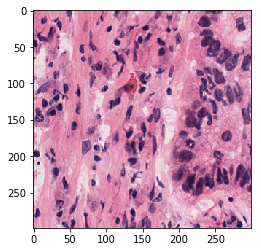

In [30]:
a = img_names[0]
img = load_img(a)
img = img_to_array(img)
print(img.shape, img.dtype)
plt.imshow(img.astype(np.uint8))
plt.show()

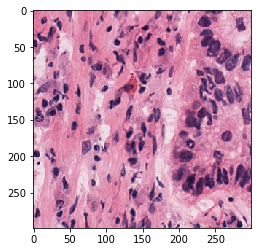

In [31]:
img = cv2.imread(a)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

#### quiz1

In [17]:
import math

n = 2
m = 1
ai = [3, 2]

amax = max(ai)
# aminus = sum([amax-i for i in ai])
aminus = amax * n - sum(ai)
kmin = max(0, math.ceil((m - aminus) / n)) + amax
kmax = amax + m
print(kmin, kmax)

3 4


#### quiz2

In [45]:
def n_in_k(n, k):
#     n -= 1
#     k -= 1
    res = 1
    tmp = 1
    for i in range(0, k):
        res *= n-i
        tmp *= i+1
    res /= tmp
    return int(res)

print(n_in_k(3, 2))

3


In [55]:
from itertools import combinations

n = 3
k = 2
def n_in_k(n, k):
    combins = [c for c in  combinations(range(n), k)]
#     print(len(combins))
    return len(combins)

In [57]:
n = 6
m = 6
MOD = 666666666

res = 0
for i in range(m, n):
    ii = n - i
    for j in range(1, ii+1):
        res += n_in_k(ii, j)
        res %= MOD
print(res)

0
